In [16]:
import networkx as nx
import numpy as np
import datetime
import matplotlib.pyplot as plt
import utils
from gem.embedding.static_graph_embedding import StaticGraphEmbedding
from gem.utils import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding

import n2v as N2V
import Tweet as tweet
from gensim.models import Word2Vec

from time import time

In [17]:

MONTH_TAG="month"
YEAR_TAG="year"
DAY_TAG="day"
TWEET_TAG="tweet"

MONTH_NAMES = {1:"JAN",2:"FEB",3:"MAR",4:"APR",
          5:"MAY",6:"JUN",7:"JUL",8:"AUG",
         9:"SEP",10:"OCT",11:"NOV",12:"DEC"}

def sampleTweets():
    tweets = []
    t1 = tweet.Tweet("Helin","bugün hava çok güzel",datetime.datetime.strptime("01.01.2019",'%d.%m.%Y'))
    t2 = tweet.Tweet("Burcu","bugün hava güneşli",datetime.datetime.strptime("02.02.2018",'%d.%m.%Y'))
    tweets.append(t1)
    tweets.append(t2)
    return tweets 

In [18]:


def create_graph(tweets):
    G1 = nx.Graph()

    for tweet in tweets:
        G1.add_node(tweet.user)
        tweetFormat = "tweet_{user}_{id}".format(user=tweet.user,id=tweet.num)
        G1.add_edge(tweet.user,tweetFormat,weight=1.0)
        #G1.add_edge(YEAR_TAG,tweet.date.year,weight=15.0)
        #G.add_edge(tweet.date.year,YEAR_TAG,weight=1.0)
        for word in tweet.text.split():
            G1.add_edge(word,tweetFormat,weight=1.0)
            #print(word)
        monthFormat = "{month}.{year}".format(month=tweet.date.month,year=tweet.date.year)
        
        G1.add_edge(str(tweet.date.year),monthFormat,weight=1.0)
        G.add_edge(monthFormat,str(tweet.date.year),weight=1.0)
        
        dayFormat = "{day}.{month}.{year}".format(day=tweet.date.day,month=tweet.date.month,year=tweet.date.year)
        G1.add_edge(monthFormat,dayFormat,weight=1.0)
        G1.add_edge(dayFormat,tweetFormat,weight=1.0)
    return G1

In [19]:
tweets = sampleTweets()
G = nx.Graph()
G = create_graph(tweets)

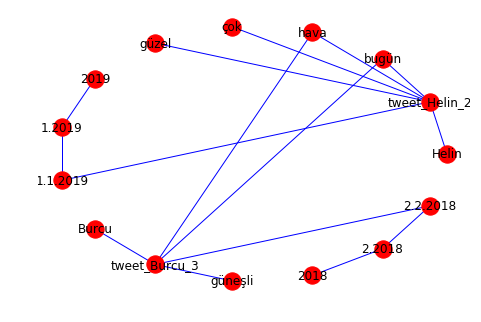

In [20]:
nx.draw(G,with_labels=True,pos=nx.circular_layout(G),nodecolor='r', edge_color='b')

In [21]:
for edge in G.edges():
	G[edge[0]][edge[1]]['weight'] = 1

In [22]:
models = []
models.append(N2V.Graph(G, is_directed=False, p=1.0, q=0.1))
models.append(GraphFactorization(d=2, max_iter=50000, eta=1 * 10**-4, regu=1.0))
models.append(HOPE(d=4, beta=0.01))
models.append(LaplacianEigenmaps(d=2))
models.append(LocallyLinearEmbedding(d=2))


Num nodes: 15, num edges: 15
Node2Vec:
	Training time: 1.192030


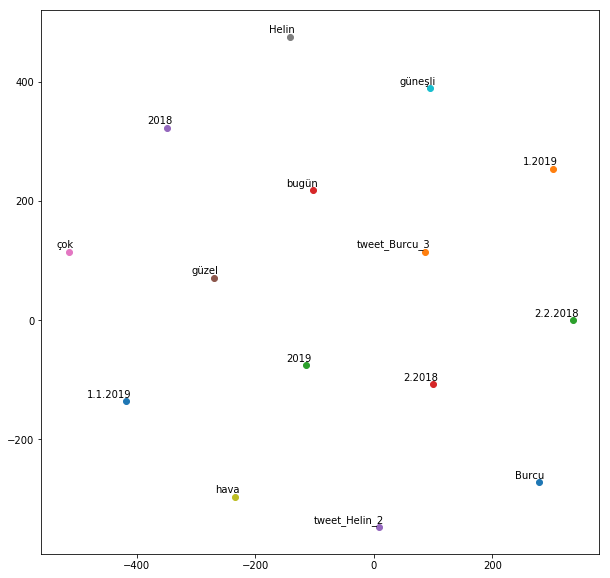

Num nodes: 15, num edges: 15
		Iter id: 0, Objective: 0.00258153, f1: 0, f2: 0.00258153
		Iter id: 10000, Objective: 0.00258153, f1: 0, f2: 0.00258153
		Iter id: 20000, Objective: 0.00258153, f1: 0, f2: 0.00258153
		Iter id: 30000, Objective: 0.00258153, f1: 0, f2: 0.00258153
		Iter id: 40000, Objective: 0.00258153, f1: 0, f2: 0.00258153
graph_factor_sgd:
	Training time: 0.968403


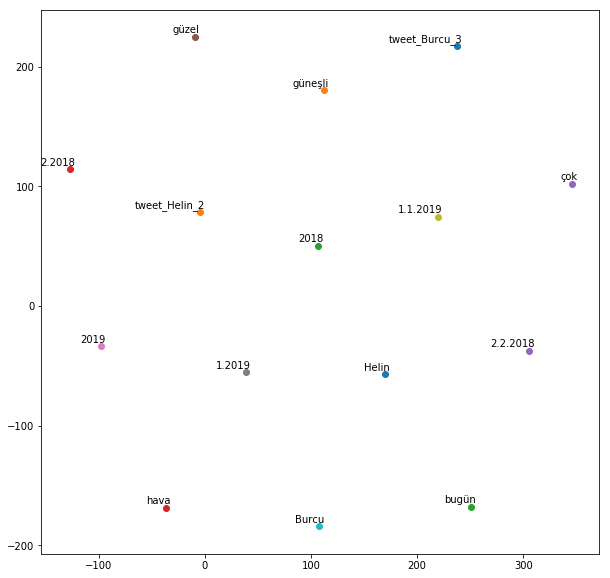

Num nodes: 15, num edges: 15
SVD error (low rank): 0.038133
hope_gsvd:
	Training time: 0.001995


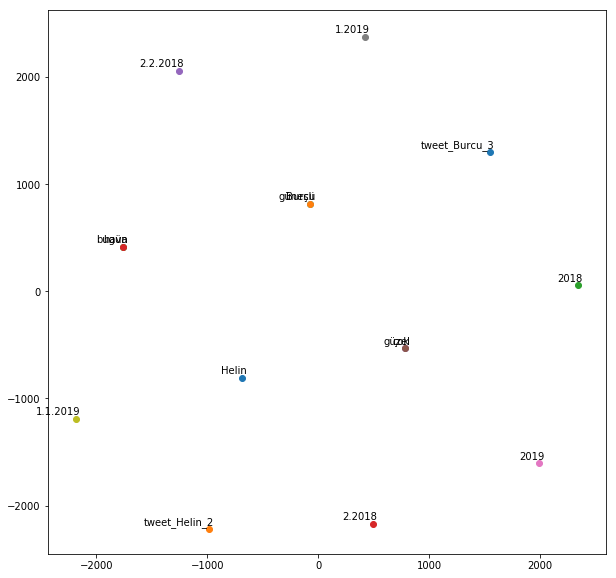

Num nodes: 15, num edges: 15
Laplacian matrix recon. error (low rank): 4.566927
lap_eigmap_svd:
	Training time: 0.003007


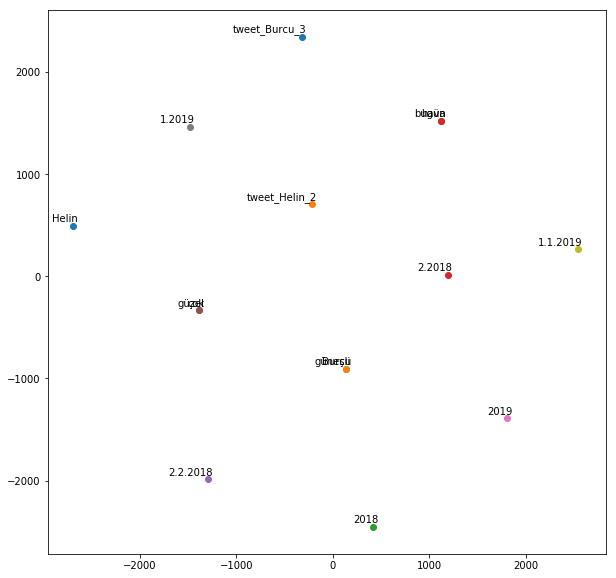

Num nodes: 15, num edges: 15
lle_svd:
	Training time: 0.002996


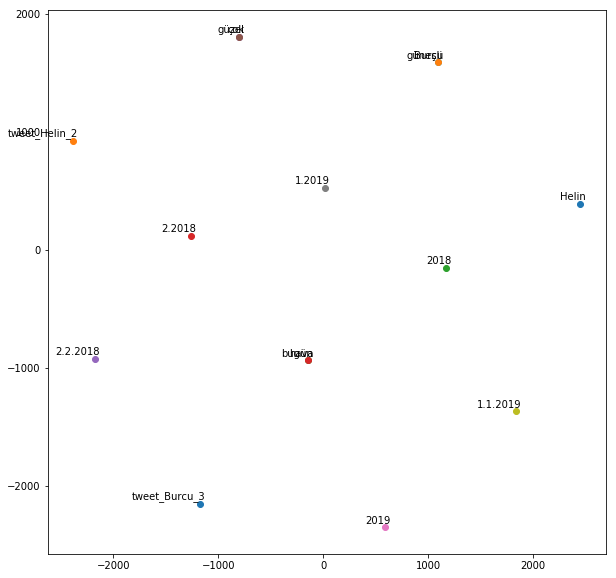

In [23]:
for embedding in models:
    print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
    t1 = time()
    # Learn embedding - accepts a networkx graph or file with edge list
    Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=False, no_python=False)
    print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
    if embedding._method_name == 'Node2Vec':
        utils.draw_tsne(Y,fig_size=(10,10))
    else:
        utils.draw_tsne2(Y,fig_size=(10,10))
    #print(Y)